# Import Libraries




In [1]:
# !pip -q install datasets seqeval scikit-learn matplotlib

!pip -q install datasets seqeval scikit-learn matplotlib

import os, re, random, unicodedata
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt

from datasets import load_dataset
from seqeval.metrics import classification_report, f1_score as seqeval_f1
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# Reproducibility

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

Device: cuda


# Load dataset

In [3]:
ds = load_dataset("rinabuoy/khmer-ner-dataset")
print(ds)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/278 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/13.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/47384 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 47384
    })
})


In [4]:
for i in range(5):
    print(f"\n--- Example {i} ---")
    print(ds["train"][i]["text"])


--- Example 0 ---
ប្រធាន [PER]ជាម ម៉ូនីកា[/PER] ថ្មីរបស់ [LOC]ព្រៃឈរ[/LOC] បាននិយាយកាលពីថ្ងៃអង្គារថា ការលើកទឹកចិត្តរបស់អឺរ៉ុបដែលមានគោលបំណងបញ្ចុះបញ្ចូល [LOC]សង្កាត់ពងទឹក[/LOC] ឱ្យបញ្ចប់កម្មវិធីនុយក្លេអ៊ែររបស់ខ្លួនគឺជាការប្រមាថដល់ប្រជាជាតិអ៊ីរ៉ង់។

--- Example 1 ---
មន្ត្រីម្នាក់ជាមួយក្រុមហ៊ុនអាឡឺម៉ង់ [PER]អាង វង្សសុជាតា[/PER] , [PER]គួច សុភាពសុវណ្ណសំណាង[/PER] បាននិយាយថា ខ្មាន់កាំភ្លើងបានបញ្ឈប់ទូកផ្គត់ផ្គង់កាលពីថ្ងៃពុធ ខណៈដែលវាធ្វើដំណើរពីរដ្ឋ Delta ទៅកាន់រដ្ឋ Bayelsa ដើម្បីត្រួតពិនិត្យអណ្តូងប្រេងនៅឯនាយសមុទ្រដែលជាកម្មសិទ្ធិរបស់ក្រុមហ៊ុន Royal - Dutch Shell ។

--- Example 2 ---
ក្រុមឧទ្ទាមអ៊ិស្លាមដែលសង្ស័យបានបាញ់កាំភ្លើងត្បាល់នៅវិមានដែលប្រើដោយប្រធានាធិបតីបណ្តោះអាសន្នរបស់ [LOC]សង្កាត់ក្រាំងធ្នង់[/LOC] [PER]ដួង តារារស្មី[/PER] ។

--- Example 3 ---
ប៉ូលីសអង់គ្លេសបាននិយាយថា ពួកគេបានចាប់ខ្លួនបុរសម្នាក់ដែលស្លៀកពាក់ជាអ្នកបំផ្ទុះគ្រាប់បែកអត្តឃាតនៅក្នុងបាតុកម្មប្រឆាំងនឹងការបោះពុម្ពរូបថ្លុកដែលពណ៌នាអំពី លោកស្រី [PER]សាលី ស៊ូឡឺវ៉ាន់[/PER] របស់សាសនាអ៊ីស្លាម។

--- Example 4 ---
ប៉ូលីស Bedfordshire បានន

In [5]:
import re
from collections import Counter

tag_pattern = re.compile(r"\[([A-Z]+)\]")  # only valid NER tags
tag_counter = Counter()

for ex in ds["train"]:
    tags = tag_pattern.findall(ex["text"])
    tag_counter.update(tags)

tag_counter

Counter({'PER': 81969, 'LOC': 34725})

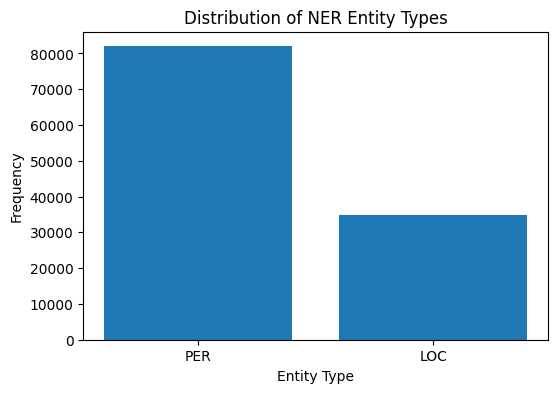

In [6]:
import matplotlib.pyplot as plt

labels = list(tag_counter.keys())
counts = list(tag_counter.values())

plt.figure(figsize=(6,4))
plt.bar(labels, counts)
plt.xlabel("Entity Type")
plt.ylabel("Frequency")
plt.title("Distribution of NER Entity Types")
plt.show()


In [7]:
lengths = [len(ex["text"]) for ex in ds["train"]]

print("Min length:", min(lengths))
print("Max length:", max(lengths))
print("Average length:", sum(lengths) / len(lengths))

Min length: 17
Max length: 1407
Average length: 269.7701966908661


In [8]:
def remove_inline_tags(text):
    return re.sub(r"\[(\/)?\w+\]", "", text)

clean_lengths = [len(remove_inline_tags(ex["text"])) for ex in ds["train"]]

print("Clean max length:", max(clean_lengths))
print("Clean avg length:", sum(clean_lengths) / len(clean_lengths))

Clean max length: 1319
Clean avg length: 242.6810526760088


In [9]:
PATTERN = re.compile(r"\[(PER|LOC|ORG)\](.*?)\[/\1\]")

def normalize_text(s: str) -> str:
    # Khmer text often includes zero-width characters in web text
    return unicodedata.normalize("NFC", s).replace("\u200b", "").replace("\ufeff", "")

def ws_tokens(s: str):
    # Lecture-friendly: keep it simple (space tokenization) to match dataset markup structure
    return [t for t in s.strip().split() if t.strip()]

def parse_annotated(text: str):
    text = normalize_text(text)
    words, tags = [], []
    last = 0

    for m in PATTERN.finditer(text):
        # pre-entity chunk → O
        pre = text[last:m.start()]
        if pre.strip():
            toks = ws_tokens(pre)
            words += toks
            tags  += ["O"] * len(toks)

        ent_type = m.group(1)
        ent_text = m.group(2)
        ent_toks = ws_tokens(ent_text)

        if ent_toks:
            words.append(ent_toks[0]); tags.append(f"B-{ent_type}")
            for t in ent_toks[1:]:
                words.append(t); tags.append(f"I-{ent_type}")

        last = m.end()

    # post-entity chunk → O
    post = text[last:]
    if post.strip():
        toks = ws_tokens(post)
        words += toks
        tags  += ["O"] * len(toks)

    return words, tags

samples = []
for ex in ds["train"]:
    w, t = parse_annotated(ex["text"])
    if w:
        samples.append({"words": w, "tags": t, "raw": ex["text"]})

print("Parsed samples:", len(samples))
print("Example raw:")
print(samples[0]["raw"])
print("Example tokens/tags:", list(zip(samples[0]["words"][:10], samples[0]["tags"][:10])))


Parsed samples: 47384
Example raw:
ប្រធាន [PER]ជាម ម៉ូនីកា[/PER] ថ្មីរបស់ [LOC]ព្រៃឈរ[/LOC] បាននិយាយកាលពីថ្ងៃអង្គារថា ការលើកទឹកចិត្តរបស់អឺរ៉ុបដែលមានគោលបំណងបញ្ចុះបញ្ចូល [LOC]សង្កាត់ពងទឹក[/LOC] ឱ្យបញ្ចប់កម្មវិធីនុយក្លេអ៊ែររបស់ខ្លួនគឺជាការប្រមាថដល់ប្រជាជាតិអ៊ីរ៉ង់។
Example tokens/tags: [('ប្រធាន', 'O'), ('ជាម', 'B-PER'), ('ម៉ូនីកា', 'I-PER'), ('ថ្មីរបស់', 'O'), ('ព្រៃឈរ', 'B-LOC'), ('បាននិយាយកាលពីថ្ងៃអង្គារថា', 'O'), ('ការលើកទឹកចិត្តរបស់អឺរ៉ុបដែលមានគោលបំណងបញ្ចុះបញ្ចូល', 'O'), ('សង្កាត់ពងទឹក', 'B-LOC'), ('ឱ្យបញ្ចប់កម្មវិធីនុយក្លេអ៊ែររបស់ខ្លួនគឺជាការប្រមាថដល់ប្រជាជាតិអ៊ីរ៉ង់។', 'O')]


In [10]:
# Dataset statistics + visuals
sent_lens = [len(s["words"]) for s in samples]
tag_counts = {}
for s in samples:
    for tag in s["tags"]:
        tag_counts[tag] = tag_counts.get(tag, 0) + 1

print("Sentence length: min/mean/max =", min(sent_lens), np.mean(sent_lens), max(sent_lens))
print("Tag counts (top 10):", sorted(tag_counts.items(), key=lambda x: -x[1])[:10])

Sentence length: min/mean/max = 2 19.038114131352355 133
Tag counts (top 10): [('O', 698447), ('I-PER', 84439), ('B-PER', 81952), ('B-LOC', 34725), ('I-LOC', 2539)]


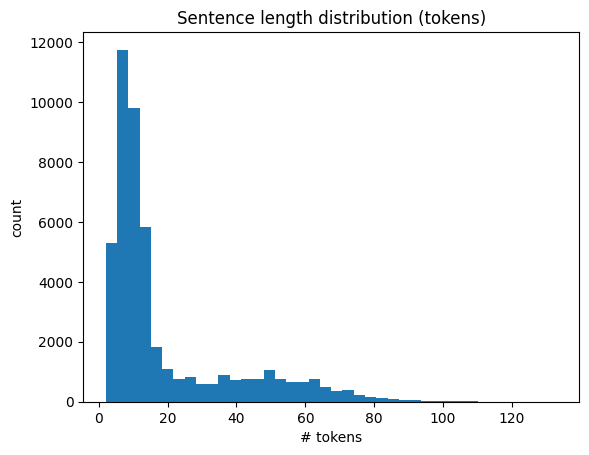

In [11]:
# 1) Sentence length histogram
plt.figure()
plt.hist(sent_lens, bins=40)
plt.title("Sentence length distribution (tokens)")
plt.xlabel("# tokens")
plt.ylabel("count")
plt.show()

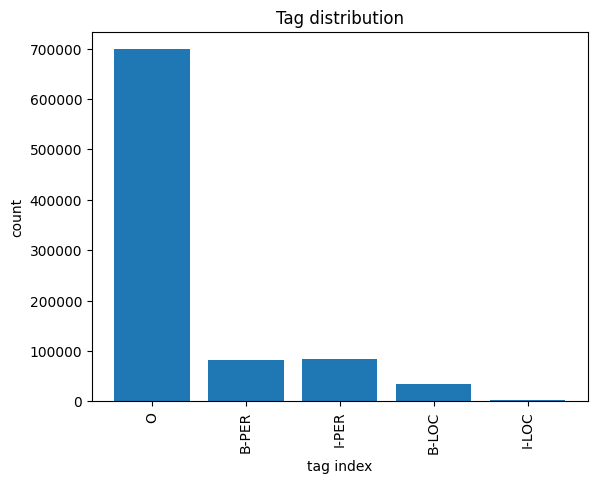

In [12]:
# 2) Tag distribution bar chart
plt.figure()
keys = list(tag_counts.keys())
vals = [tag_counts[k] for k in keys]
plt.bar(range(len(keys)), vals)
plt.title("Tag distribution")
plt.xlabel("tag index")
plt.ylabel("count")
plt.xticks(range(len(keys)), keys, rotation=90)
plt.show()

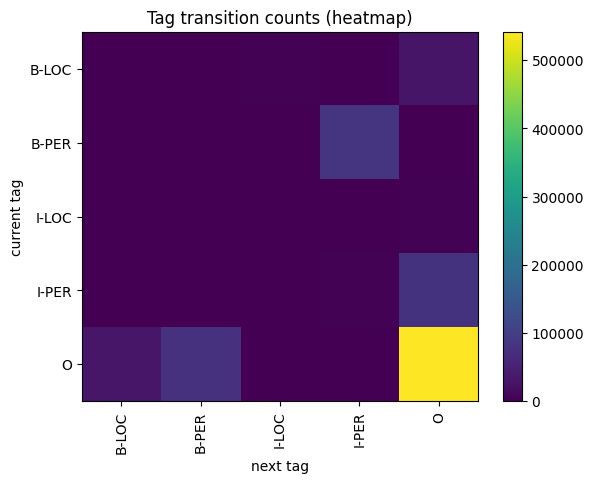

In [13]:

# 3) BIO transition heatmap
tags_sorted = sorted(tag_counts.keys())
idx = {t:i for i,t in enumerate(tags_sorted)}
M = np.zeros((len(tags_sorted), len(tags_sorted)), dtype=np.int64)
for s in samples:
    ts = s["tags"]
    for a,b in zip(ts[:-1], ts[1:]):
        M[idx[a], idx[b]] += 1

plt.figure()
plt.imshow(M, aspect="auto")
plt.title("Tag transition counts (heatmap)")
plt.xlabel("next tag")
plt.ylabel("current tag")
plt.xticks(range(len(tags_sorted)), tags_sorted, rotation=90)
plt.yticks(range(len(tags_sorted)), tags_sorted)
plt.colorbar()
plt.show()

# Character vocab + encoding

In [14]:
all_words = [w for s in samples for w in s["words"]]
chars = set()
for w in all_words:
    for ch in normalize_text(w):
        if ch.strip():
            chars.add(ch)

PAD = "<PAD>"
UNK = "<UNK>"
idx2char = [PAD, UNK] + sorted(chars)
char2idx = {c:i for i,c in enumerate(idx2char)}

print("Char vocab size:", len(idx2char))
print("Sample chars:", idx2char[:30])

MAX_WORD_LEN = 24  # keep consistent across AE + NER

def encode_word(word: str, max_len=MAX_WORD_LEN):
    word = normalize_text(word)
    ids = []
    for ch in word[:max_len]:
        ids.append(char2idx.get(ch, char2idx[UNK]))
    if len(ids) < max_len:
        ids += [char2idx[PAD]] * (max_len - len(ids))
    return ids

def true_char_len(word: str, max_len=MAX_WORD_LEN):
    return min(len(normalize_text(word)), max_len)

Char vocab size: 258
Sample chars: ['<PAD>', '<UNK>', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=']


# Char AutoEncoder (pretrain)

AE epoch 01 | train CE/token=0.1330 | val CE/token=0.0009
AE epoch 02 | train CE/token=0.0005 | val CE/token=0.0002
AE epoch 03 | train CE/token=0.0002 | val CE/token=0.0001
AE epoch 04 | train CE/token=0.0001 | val CE/token=0.0001
AE epoch 05 | train CE/token=0.0001 | val CE/token=0.0000
AE epoch 06 | train CE/token=0.0000 | val CE/token=0.0000
AE epoch 07 | train CE/token=0.0000 | val CE/token=0.0000
AE epoch 08 | train CE/token=0.0000 | val CE/token=0.0000


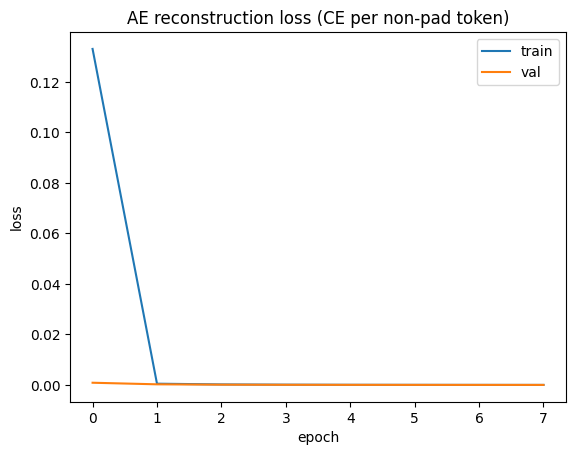

Reconstruction samples:
orig: ដោយសារការបាត់បង់យុទ្ធជនតស៊ូដើម្បីសហគមន៍
reco: ដោយសារការបាត់បង់យុទ្ធជនត
----------------------------------------
orig: សុវិជ្ជាសុខឃឹម
reco: សុវិជ្ជាសុខឃឹម
----------------------------------------
orig: គឺឧត្តមសេនីយ៍
reco: គឺឧត្តមសេនីយ៍
----------------------------------------
orig: វឌ្ឃនាកន្និថា
reco: វឌ្ឃនាកន្និថា
----------------------------------------
orig: 5
reco: 5
----------------------------------------
orig: _
reco: _
----------------------------------------
orig: ថ្ងៃសៅរ៍
reco: ថ្ងៃសៅរ៍
----------------------------------------
orig: ដែល
reco: ដែល
----------------------------------------
orig: យ៉ែម
reco: យ៉ែម
----------------------------------------
orig: បានធ្វើ
reco: បានធ្វើ
----------------------------------------
orig: មុខតំណែង
reco: មុខតំណែង
----------------------------------------
orig: ពេលចុះពិនិត្យកន្លែងកើតហេតុ
reco: ពេលចុះពិនិត្យកន្លែងកើតហេ
----------------------------------------


In [15]:
class CharEncoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=64, hid_dim=128, pad_idx=0):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.rnn = nn.GRU(emb_dim, hid_dim, batch_first=True)

    def forward(self, x, lengths):
        e = self.emb(x)  # (B, C, emb)
        packed = pack_padded_sequence(e, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, h = self.rnn(packed)   # h: (1, B, hid)
        return h.squeeze(0)       # (B, hid)

class CharDecoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=64, hid_dim=128, pad_idx=0):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.rnn = nn.GRU(emb_dim, hid_dim, batch_first=True)
        self.fc  = nn.Linear(hid_dim, vocab_size)

    def forward(self, x, lengths, h0):
        e = self.emb(x)
        packed = pack_padded_sequence(e, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.rnn(packed, h0.unsqueeze(0))
        out, _ = pad_packed_sequence(packed_out, batch_first=True, total_length=x.size(1))
        logits = self.fc(out)
        return logits  # (B, C, vocab)

class CharAE(nn.Module):
    def __init__(self, vocab_size, emb_dim=64, hid_dim=128, pad_idx=0):
        super().__init__()
        self.encoder = CharEncoder(vocab_size, emb_dim, hid_dim, pad_idx)
        self.decoder = CharDecoder(vocab_size, emb_dim, hid_dim, pad_idx)

    def forward(self, x, lengths):
        h = self.encoder(x, lengths)          # (B, hid)
        logits = self.decoder(x, lengths, h)  # (B, C, vocab)
        return logits, h

ae = CharAE(len(idx2char)).to(DEVICE)

ae_words = [w for w in all_words if true_char_len(w) > 0]
ae_train, ae_val = train_test_split(ae_words, test_size=0.1, random_state=SEED)

class WordCharDataset(Dataset):
    def __init__(self, words):
        self.words = words
    def __len__(self): return len(self.words)
    def __getitem__(self, i):
        w = self.words[i]
        x = torch.tensor(encode_word(w), dtype=torch.long)
        L = true_char_len(w)
        return x, L, w

def collate_wordchars(batch):
    xs, ls, ws = zip(*batch)
    x = torch.stack(xs, dim=0)
    l = torch.tensor(ls, dtype=torch.long)
    return x, l, ws

BATCH_AE = 512
train_loader_ae = DataLoader(WordCharDataset(ae_train), batch_size=BATCH_AE, shuffle=True, collate_fn=collate_wordchars)
val_loader_ae   = DataLoader(WordCharDataset(ae_val),   batch_size=BATCH_AE, shuffle=False, collate_fn=collate_wordchars)

opt_ae = torch.optim.Adam(ae.parameters(), lr=1e-3)
ce_char = nn.CrossEntropyLoss(ignore_index=char2idx[PAD])

def run_ae_epoch(loader, train=True):
    ae.train(train)
    tot_loss, tot_tok = 0.0, 0
    for x, l, _ in loader:
        x, l = x.to(DEVICE), l.to(DEVICE)
        if train:
            opt_ae.zero_grad()
        logits, _ = ae(x, l)
        loss = ce_char(logits.reshape(-1, logits.size(-1)), x.reshape(-1))
        if train:
            loss.backward()
            nn.utils.clip_grad_norm_(ae.parameters(), 1.0)
            opt_ae.step()
        nonpad = (x != char2idx[PAD]).sum().item()
        tot_loss += loss.item() * nonpad
        tot_tok  += nonpad
    return tot_loss / max(1, tot_tok)

EPOCHS_AE = 8
train_losses, val_losses = [], []
for ep in range(1, EPOCHS_AE+1):
    tr = run_ae_epoch(train_loader_ae, train=True)
    va = run_ae_epoch(val_loader_ae, train=False)
    train_losses.append(tr); val_losses.append(va)
    print(f"AE epoch {ep:02d} | train CE/token={tr:.4f} | val CE/token={va:.4f}")

plt.figure()
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.title("AE reconstruction loss (CE per non-pad token)")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

@torch.no_grad()
def reconstruct(word: str):
    x = torch.tensor(encode_word(word), dtype=torch.long).unsqueeze(0).to(DEVICE)
    l = torch.tensor([true_char_len(word)], dtype=torch.long).to(DEVICE)
    logits, _ = ae(x, l)
    pred = logits.argmax(-1)[0, :l.item()].tolist()
    return "".join(idx2char[i] for i in pred if i > 1)

print("Reconstruction samples:")
for w in ae_val[:12]:
    print("orig:", w)
    print("reco:", reconstruct(w))
    print("-"*40)



# NER dataset (BIO)

In [16]:

all_tags = sorted({t for s in samples for t in s["tags"]})
tag2idx = {t:i for i,t in enumerate(all_tags)}
idx2tag = {i:t for t,i in tag2idx.items()}

class NERDataset(Dataset):
    def __init__(self, items):
        self.items = items
    def __len__(self): return len(self.items)
    def __getitem__(self, i):
        s = self.items[i]
        words = s["words"]
        tags  = s["tags"]
        X = torch.tensor([encode_word(w) for w in words], dtype=torch.long)      # (T,C)
        Lc = torch.tensor([true_char_len(w) for w in words], dtype=torch.long)  # (T,)
        y = torch.tensor([tag2idx[t] for t in tags], dtype=torch.long)          # (T,)
        return X, Lc, y, words

def collate_ner(batch):
    Xs, Lcs, ys, words = zip(*batch)
    T_max = max(x.size(0) for x in Xs)

    B = len(Xs)
    X = torch.full((B, T_max, MAX_WORD_LEN), fill_value=char2idx[PAD], dtype=torch.long)
    Lc = torch.zeros((B, T_max), dtype=torch.long)
    y = torch.full((B, T_max), fill_value=-100, dtype=torch.long)
    mask = torch.zeros((B, T_max), dtype=torch.bool)

    for i,(x,lc,yy) in enumerate(zip(Xs,Lcs,ys)):
        T = x.size(0)
        X[i,:T] = x
        Lc[i,:T] = lc
        y[i,:T] = yy
        mask[i,:T] = True

    return X, Lc, y, mask, words

train_items, test_items = train_test_split(samples, test_size=0.15, random_state=SEED)
train_items, val_items  = train_test_split(train_items, test_size=0.15, random_state=SEED)

print("NER split sizes:", len(train_items), len(val_items), len(test_items))

BATCH_NER = 32
train_loader = DataLoader(NERDataset(train_items), batch_size=BATCH_NER, shuffle=True, collate_fn=collate_ner)
val_loader   = DataLoader(NERDataset(val_items),   batch_size=BATCH_NER, shuffle=False, collate_fn=collate_ner)
test_loader  = DataLoader(NERDataset(test_items),  batch_size=BATCH_NER, shuffle=False, collate_fn=collate_ner)

NER split sizes: 34234 6042 7108


# NER model (BIO only, frozen AE encoder)

In [17]:
class NERModel(nn.Module):
    def __init__(self, ae_model: CharAE, hid_dim=128, ctx_hid=128, n_tags=None):
        super().__init__()
        self.char_encoder = ae_model.encoder

        # Freeze encoder parameters
        for p in self.char_encoder.parameters():
            p.requires_grad = False

        self.ctx_rnn = nn.GRU(hid_dim, ctx_hid, batch_first=True, bidirectional=True)
        self.bio_head = nn.Linear(ctx_hid*2, n_tags)

    def forward(self, X, Lc, mask):
        B, T, C = X.shape
        Xf = X.view(B*T, C)
        Lf = Lc.view(B*T)

        Lf_safe = torch.clamp(Lf, min=1)

        with torch.no_grad():
            h = self.char_encoder(Xf, Lf_safe)  # (B*T, hid)
        H = h.view(B, T, -1)

        out, _ = self.ctx_rnn(H)
        bio_logits = self.bio_head(out)
        return bio_logits

def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X, Lc, y, mask, _words in loader:
            X, Lc, y, mask = X.to(DEVICE), Lc.to(DEVICE), y.to(DEVICE), mask.to(DEVICE)
            bio_logits = model(X, Lc, mask)
            pred = bio_logits.argmax(-1)

            for i in range(X.size(0)):
                true_tags = []
                pred_tags = []
                for j in range(X.size(1)):
                    if not mask[i,j]:
                        continue
                    true_id = y[i,j].item()
                    pred_id = pred[i,j].item()
                    true_tags.append(idx2tag[true_id])
                    pred_tags.append(idx2tag[pred_id])
                y_true.append(true_tags)
                y_pred.append(pred_tags)

    f1 = seqeval_f1(y_true, y_pred)
    return f1, y_true, y_pred

def train_ner(epochs=8, lr=3e-3):
    model = NERModel(ae, n_tags=len(all_tags)).to(DEVICE)

    opt = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=lr)
    ce_bio = nn.CrossEntropyLoss(ignore_index=-100)

    history = {"train_loss": [], "val_f1": []}
    best_f1 = -1
    best_state = None

    for ep in range(1, epochs+1):
        model.train()
        tot_loss, tot_steps = 0.0, 0

        for X, Lc, y, mask, _ in train_loader:
            X, Lc, y, mask = X.to(DEVICE), Lc.to(DEVICE), y.to(DEVICE), mask.to(DEVICE)

            bio_logits = model(X, Lc, mask)
            loss = ce_bio(bio_logits.reshape(-1, bio_logits.size(-1)), y.reshape(-1))

            opt.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

            tot_loss += loss.item()
            tot_steps += 1

        avg_loss = tot_loss / max(1, tot_steps)
        val_f1, _, _ = evaluate(model, val_loader)

        history["train_loss"].append(avg_loss)
        history["val_f1"].append(val_f1)

        print(f"Epoch {ep:02d} | loss={avg_loss:.4f} | val F1={val_f1:.4f}")

        if val_f1 > best_f1:
            best_f1 = val_f1
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    model.load_state_dict(best_state)
    return model, history


# Train

Epoch 01 | loss=0.1390 | val F1=0.8828
Epoch 02 | loss=0.0790 | val F1=0.8993
Epoch 03 | loss=0.0651 | val F1=0.9063
Epoch 04 | loss=0.0568 | val F1=0.9136
Epoch 05 | loss=0.0514 | val F1=0.9320
Epoch 06 | loss=0.0477 | val F1=0.9312
Epoch 07 | loss=0.0445 | val F1=0.9335
Epoch 08 | loss=0.0423 | val F1=0.9393


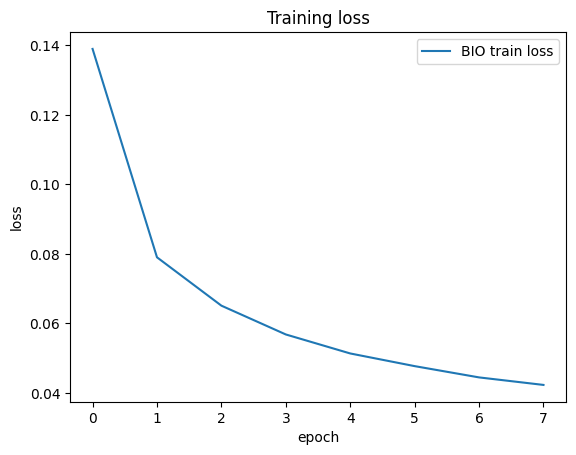

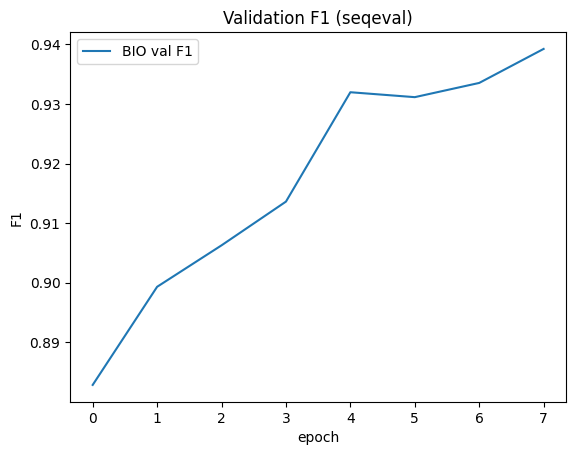

In [18]:
model_bio, hist_bio = train_ner(epochs=8, lr=3e-3)

plt.figure()
plt.plot(hist_bio["train_loss"], label="BIO train loss")
plt.title("Training loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(hist_bio["val_f1"], label="BIO val F1")
plt.title("Validation F1 (seqeval)")
plt.xlabel("epoch")
plt.ylabel("F1")
plt.legend()
plt.show()

# Test

TEST F1 (BIO): 0.939816388983339

BIO Classification report (BIO model):
              precision    recall  f1-score   support

         LOC     0.8580    0.9028    0.8798      5142
         PER     0.9592    0.9717    0.9654     12290

   micro avg     0.9286    0.9514    0.9398     17432
   macro avg     0.9086    0.9372    0.9226     17432
weighted avg     0.9294    0.9514    0.9402     17432



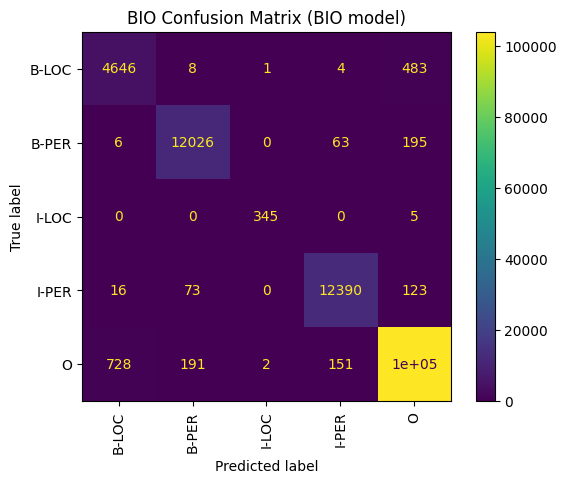

In [19]:
test_f1_bio, ytrue_bio, ypred_bio = evaluate(model_bio, test_loader)
print("TEST F1 (BIO):", test_f1_bio)

print("\nBIO Classification report (BIO model):")
print(classification_report(ytrue_bio, ypred_bio, digits=4))

def flatten_tags(ytrue, ypred):
    yt, yp = [], []
    for a,b in zip(ytrue, ypred):
        yt += [tag2idx[t] for t in a]
        yp += [tag2idx[t] for t in b]
    return yt, yp

yt, yp = flatten_tags(ytrue_bio, ypred_bio)
cm = confusion_matrix(yt, yp, labels=list(range(len(all_tags))))
disp = ConfusionMatrixDisplay(cm, display_labels=all_tags)
disp.plot(xticks_rotation=90)
plt.title("BIO Confusion Matrix (BIO model)")
plt.show()



# Demo

In [20]:
@torch.no_grad()
def predict(sentence: str, model):
    model.eval()
    words = ws_tokens(normalize_text(sentence))
    if not words:
        return []
    X = torch.tensor([encode_word(w) for w in words], dtype=torch.long).unsqueeze(0).to(DEVICE)
    Lc = torch.tensor([[true_char_len(w) for w in words]], dtype=torch.long).to(DEVICE)
    mask = torch.ones((1, len(words)), dtype=torch.bool).to(DEVICE)

    bio_logits = model(X, Lc, mask)
    pred = bio_logits.argmax(-1)[0].tolist()
    return list(zip(words, [idx2tag[i] for i in pred]))

demo1 = "ខេត្ត កំពង់ស្ពឺ ជាស្រុកកំណើតរបស់ខ្ញុំ"
demo2 = "រាជធានីភ្នំពេញ , កញ្ញា ប៊ុន រតនាទេពី ជានិស្សិតនៅវិទ្យាស្ថាន បច្ចេកវិទ្យាកម្ពុជា"

print("Demo1:", predict(demo1, model_bio)[:40])
print("Demo2:", predict(demo2, model_bio)[:60])

Demo1: [('ខេត្ត', 'O'), ('កំពង់ស្ពឺ', 'B-LOC'), ('ជាស្រុកកំណើតរបស់ខ្ញុំ', 'O')]
Demo2: [('រាជធានីភ្នំពេញ', 'O'), (',', 'O'), ('កញ្ញា', 'O'), ('ប៊ុន', 'B-PER'), ('រតនាទេពី', 'I-PER'), ('ជានិស្សិតនៅវិទ្យាស្ថាន', 'O'), ('បច្ចេកវិទ្យាកម្ពុជា', 'B-LOC')]


In [20]:
import torch
import json
import os
from collections import Counter


In [22]:
model_bio.eval()
print("Training finished")

Training finished


In [23]:
SAVE_DIR = "deployment"
os.makedirs(SAVE_DIR, exist_ok=True)
print("Deployment folder ready")


Deployment folder ready


In [25]:
MODEL_PATH = os.path.join(SAVE_DIR, "model.pt")
torch.save(model_bio.state_dict(), MODEL_PATH)

print("Model saved to", MODEL_PATH)

Model saved to deployment/model.pt


In [28]:
import json

embedding_dim = ae.encoder.emb.embedding_dim # Char embedding dimension
hidden_dim = model_bio.ctx_rnn.hidden_size # Context RNN hidden dimension

config = {
    "model_type": "NER",
    "architecture": "BiLSTM",
    "embedding_dim": embedding_dim,
    "hidden_dim": hidden_dim,
    "num_labels": len(all_tags)
}

with open(os.path.join(SAVE_DIR, "config.json"), "w", encoding="utf-8") as f:
    json.dump(config, f, ensure_ascii=False, indent=2)

print("Config saved")

Config saved


In [30]:
import json

# Create word2idx from all_words
all_unique_words = sorted(list(set(all_words)))
word2idx = {word: i for i, word in enumerate(all_unique_words)}

with open(os.path.join(SAVE_DIR, "vocab.json"), "w", encoding="utf-8") as f:
    json.dump(word2idx, f, ensure_ascii=False, indent=2)

print("Vocab saved")

Vocab saved


In [32]:
with open(os.path.join(SAVE_DIR, "label2id.json"), "w", encoding="utf-8") as f:
    json.dump(tag2idx, f, ensure_ascii=False, indent=2)

with open(os.path.join(SAVE_DIR, "id2label.json"), "w", encoding="utf-8") as f:
    json.dump(idx2tag, f, ensure_ascii=False, indent=2)

print("Label mappings saved")

Label mappings saved


In [34]:
metadata = {
    "language": "khmer",
    "task": "named_entity_recognition",
    "vocab_size": len(word2idx),
    "num_labels": len(tag2idx)
}

with open(os.path.join(SAVE_DIR, "metadata.json"), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)

print("Metadata saved")

Metadata saved


In [36]:
import json

with open("deployment/config.json", "r", encoding="utf-8") as f:
    config = json.load(f)

# Recreate the CharAE model (character autoencoder) first
# vocab_size is len(idx2char) from the global context
# emb_dim and hid_dim for CharAE were 64 and 128 (default during training), which align with config values
ae_for_deploy = CharAE(
    vocab_size=len(idx2char),
    emb_dim=config["embedding_dim"],
    hid_dim=config["hidden_dim"]
)

# Now, recreate the NERModel with the CharAE instance and other parameters
deploy_model = NERModel(
    ae_model=ae_for_deploy,
    hid_dim=ae_for_deploy.encoder.rnn.hidden_size, # Output dim of char encoder, which is CharAE's hid_dim
    ctx_hid=config["hidden_dim"], # Hidden dim for the context RNN
    n_tags=config["num_labels"]
)

deploy_model.load_state_dict(
    torch.load("deployment/model.pt", map_location="cpu")
)
deploy_model.eval()

print("Deployment model loaded successfully")

Deployment model loaded successfully
